# Морфология

In [1]:
import io
import re

from string import punctuation
from Levenshtein import distance

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Combine 'War and Peace' with full text of 'Anna Karenina', because I want to have more words/trigrams
with io.open('data/ak.txt', 'r') as text_file:
    ak = text_file.read()

with io.open('data/wp.txt', 'r') as text_file:
    wp = text_file.read()

text = ak + ' ' + wp

In [3]:
words = set(re.sub('[^а-яА-Я]', ' ', text).split())
words = set([word.lower() for word in words])

### Триграммы
Для начала получим словарь вида (триграмма: её количество в тексте), не забывая о начале и конце слова.

Далее можно построить гистограмму на количество вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [4]:
def corpus_trigrams(words):
    """
        Returns trigrams count dictionary
    """
    trigrams = {}

    for word in words:
        tmp = '##' + word + '##'
        for i in range(len(tmp) - 2):
            trigram = tmp[i: i + 3]
            if trigram in trigrams:
                trigrams[trigram] += 1
            else:
                trigrams[trigram] = 1

    return trigrams

In [5]:
trigrams = corpus_trigrams(words)

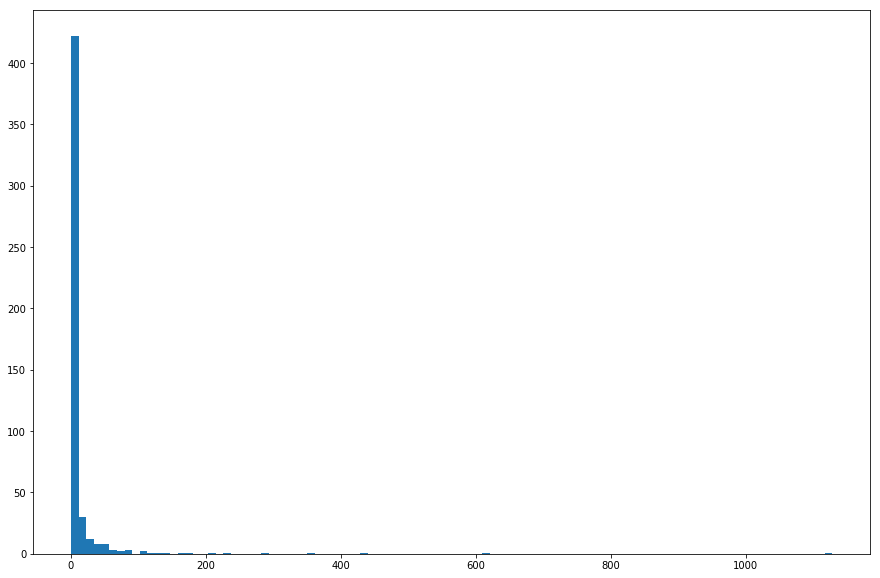

In [6]:
histogram = {}

for key, value in trigrams.items():
    if value in histogram:
        histogram[value] += 1
    else:
        histogram[value] = 1

plt.figure(figsize=(15, 10))
plt.hist(histogram.values(), bins=100)
plt.show()

In [7]:
sorted(histogram.items(), key=lambda x: -x[1])[:10]

[(1, 1128),
 (2, 610),
 (3, 435),
 (4, 352),
 (5, 293),
 (6, 234),
 (7, 205),
 (8, 176),
 (9, 164),
 (10, 137)]

In [8]:
# Looking on the results above, 7 seems as a normal threshold
THRESHOLD = 7

In [9]:
def is_error(word, trigrams, threshold=THRESHOLD, max_misses=2):
    """
        Returns True, if the word has a mistake
    """
    # Short words are usually OK
    if len(word) < 3:
        return False

    # Allow some variability
    misses = 0
    tmp = '##' + word.lower() + '##'

    for i in range(len(tmp) - 3):
        if misses >= max_misses:
            return True

        trigram = tmp[i: i + 3]
        if trigram not in trigrams:
            misses += 1
            continue

        if trigrams[trigram] < threshold:
            misses += 1

    return misses >= max_misses

In [10]:
is_error('кот', trigrams)

False

In [11]:
is_error('ыыы', trigrams)

True

### Бор

С помощью бора можно реализовать эффективный алгоритм исправления опечаток.

In [12]:
class Node:
    def __init__(self, char='#'):
        self.char = char
        self.children = []
        self.is_finished = False


class Trie:
    def __init__(self, threshold=3):
        self.root = Node()
        self.threshold = threshold

    def add(self, word):
        """
            Adds word to trie
        """
        node = self.root

        for char in word:
            is_found = False

            for child in node.children:
                if child.char == char:
                    node = child
                    is_found = True
                    break

            if not is_found:
                node.children.append(Node(char))
                node = node.children[-1]

        node.is_finished = True

    def build(self, words):
        """
            Builds a trie
        """
        for word in words:
            self.add(word)

    def traverse(self, word):
        """
            Traverses the trie and returns all words,
            that are not too far from the given word
        """
        candidates = []        
        queue, level = [(self.root, '', 0)], 0

        while True:
            tmp = []

            for node, seq, misses in queue:
                for child in node.children:
                    if level >= len(word):
                        if child.is_finished:
                            if misses + 1 < self.threshold:
                                candidates.append((seq + child.char, misses + 1))
                        if misses + 1 < self.threshold:
                            tmp.append((child, seq + child.char, misses + 1))
                    else:
                        if child.is_finished:
                            distance = misses + len(word) - len(seq)
                            if child.char == word[level]:
                                distance -= 1
                            if distance < self.threshold:
                                candidates.append((seq + child.char, distance))

                        distance = misses
                        if child.char != word[level]:
                            distance += 1
                        if distance < self.threshold:
                            tmp.append((child, seq + child.char, distance))

            if len(tmp) == 0:
                break

            level += 1
            queue = tmp

        # Wasn't able to find suitable words
        if len(candidates) == 0:
            return [word]

        min_distance = min([candidate[1] for candidate in candidates])

        return [candidate[0] for candidate in candidates if candidate[1] == min_distance]

In [13]:
def correct_word(word, dictionary):
    """
        Corrects word using trie approach
    """
    trie = Trie()
    trie.build(dictionary)

    candidates = trie.traverse(word.lower())

    return '<{}>: [{}]'.format(word, '|'.join(candidates))

In [14]:
correct_word('коровя', words)

'<коровя>: [коров|корове|корову|корова|коровы|короля]'

In [15]:
def correct_word_naive(word, dictionary):
    """
        Corrects word using naive approach (search most similar word in the dicitionary)
    """
    distances = [(candidate, distance(word.lower(), candidate)) for candidate in dictionary]
    min_distance = sorted(distances, key=lambda x: x[1])[0][1]

    candidates = [word[0] for word in distances if word[1] == min_distance]

    return '<{}>: [{}]'.format(word, '|'.join(candidates))

In [16]:
correct_word_naive('коровя', words)

'<коровя>: [коров|корове|короля|корову|корова|коровы]'

### Вместе

Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его.

In [17]:
def correct_mistakes(text, dictionary):
    """
        Corrects words in text using trie approach
    """
    clean = []

    for word in text.split():
        # Problems with bad parsing
        if len(word) > 1 and word[-1] in punctuation:
            word, punct = word[:-1], word[-1]
        else:
            word, punct = word, None

        if not is_error(word, trigrams):
            if punct:
                word += punct
            clean.append(word)
            continue

        correction = correct_word(word, dictionary)
        if punct:
            correction += punct
        clean.append(correction)

    return ' '.join(clean)

In [18]:
def correct_mistakes_naive(text, dictionary):
    """
        Corrects words in text using naive approach
    """
    clean = []

    for word in text.split():
        # Problems with bad parsing
        if len(word) > 1 and word[-1] in punctuation:
            word, punct = word[:-1], word[-1]
        else:
            word, punct = word, None

        if not is_error(word, trigrams):
            if punct:
                word += punct
            clean.append(word)
            continue

        correction = correct_word_naive(word, dictionary)
        if punct:
            correction += punct
        clean.append(correction)

    return ' '.join(clean)

In [19]:
with open('data/text.txt', 'r') as file:
    text = file.read().replace('\n', ' ')

# Generate some mistakes
text = text.replace('ов', 'св')

In [20]:
%%time
correct_mistakes(text, words)

CPU times: user 25.4 s, sys: 441 ms, total: 25.8 s
Wall time: 27.2 s


'Тверской бульвар был почти таким же, как и два года назад, когда я последний раз его видел – опять был февраль, сугробы и мгла, странным образом проникавшая даже в дневной свет. На скамейках сидели те же неподвижные старухи; вверху, над черной сеткой ветвей, серело то же небо, похожее на <ветхий>: [ветки|ветви|ветхом|веткой|ветвей|ведший|летний], до земли <прсвисший>: [прсвисший] под тяжестью спящего Бога матрац. Была, впрочем, и разница. Этой зимой по аллеям мела <какая-то>: [какая-то] ссвершенно степная метель, и, попадись мне навстречу пара <волксв>: [волков], я ссвершенно не удивился бы. <Бронзсвый>: [бронзовые|бронзовым] Пушкин казался чуть печальней, чем обычно – оттого, наверно, что на груди у него висел красный фартук с <надписью>: [надпись]: <«Да>: [ада] здравствует первая <годсвщина>: [годовщина] <Революции»>: [революции]. Но никакого желания иронизирсвать по <псводу>: [поводу] того, что <здравствсвать>: [здравствсвать] предлагалось <годсвщине>: [годовщина], а революция была

In [21]:
%%time
correct_mistakes_naive(text, words)

CPU times: user 2.07 s, sys: 28.8 ms, total: 2.1 s
Wall time: 2.19 s


'Тверской бульвар был почти таким же, как и два года назад, когда я последний раз его видел – опять был февраль, сугробы и мгла, странным образом проникавшая даже в дневной свет. На скамейках сидели те же неподвижные старухи; вверху, над черной сеткой ветвей, серело то же небо, похожее на <ветхий>: [летний|ветхом|веткой|ветки|ветвей|ведший|верхний|ветви], до земли <прсвисший>: [привыкший|проживший|привезший] под тяжестью спящего Бога матрац. Была, впрочем, и разница. Этой зимой по аллеям мела <какая-то>: [какая] ссвершенно степная метель, и, попадись мне навстречу пара <волксв>: [волков], я ссвершенно не удивился бы. <Бронзсвый>: [бронзовые|бронзовым] Пушкин казался чуть печальней, чем обычно – оттого, наверно, что на груди у него висел красный фартук с <надписью>: [надпись]: <«Да>: [да|ада] здравствует первая <годсвщина>: [годовщина] <Революции»>: [революции]. Но никакого желания иронизирсвать по <псводу>: [поводу] того, что <здравствсвать>: [здравствуйте|здравствует] предлагалось <го